## Var name setting

In [24]:
subjectID='3'
noEpochs=1000
noLSTMUnits=100

# Change to true if input file 's features are sorted by time (False by default) 
orderedInput=True

# Change to 1 if want to export to CSV O2 precict against test (0 by default)
exportCSV=0

# Chabge to 1 if want to save the training model (0 by default)
savedModel=0

# Set seed value for uniform (NOT RECOMMEND TO CHANGE, by default 12321)
seed_value = 12321

# Setting name of output files 
if orderedInput:
    fileName='inputFeatures'+subjectID+'_sorted.mat'
    modelSaveName='Subj-'+subjectID+'-'+str(noEpochs)+'pochs-order-'+str(noLSTMUnits)+'-LSTM_u.h5'
    figPredictName='Subj'+subjectID+'-'+str(noEpochs)+'pochs-order-'+str(noLSTMUnits)+'-LSTM_u.jpg'
    figRMSEName='RMSE_Subj'+subjectID+'-'+str(noEpochs)+'pochs-order-'+str(noLSTMUnits)+'-LSTM_u.jpg'

else:
    
    # Unordered input features
    fileName='inputFeatures'+subjectID+'.mat'
    modelSaveName='Subj-'+subjectID+'-'+str(noEpochs)+'pochs-'+str(noLSTMUnits)+'-LSTM_u.h5'
    figPredictName='Subj'+subjectID+'-'+str(noEpochs)+'pochs-'+str(noLSTMUnits)+'-LSTM_u.jpg'
    figRMSEName='RMSE_Subj'+subjectID+'-'+str(noEpochs)+'pochs-'+str(noLSTMUnits)+'-LSTM_u.jpg'

## Include lib

In [25]:
from keras.models import load_model
import scipy.io as sio 
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.python.client import device_lib
from datetime import datetime as dt
from keras import backend as K
#from comet_ml import Experiment

## Set seed for training

In [26]:
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Read input from Matlab file

In [27]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

i=sio.loadmat(fileName)

TTest=i['TTest']
TTrain=i['TTrain']
XTrain=i['XTrain']
XTest=i['XTest']

XTrain=XTrain.reshape(-1)
TTrain=TTrain.reshape(-1)
XTest=XTest.reshape(-1)
TTest=TTest.reshape(-1)

test=np.transpose(XTrain).reshape(-1)
test2=np.transpose(XTest).reshape(-1)

list_test=[]
for i in range(len(test)):
    test[i]=np.transpose(np.array(test[i]))
    list_test.append(test[i])

for j in range(len(test2)):  
    test2[j]=np.transpose(np.array(test2[j]))
    list_test.append(test2[j])  

    
list_test=np.vstack(list_test)
scaler = StandardScaler()
scaler=scaler.fit(list_test)
scaled_list_test=scaler.transform(list_test)

XT_s_stack=list()
i=0
while i+50 <= (len(scaled_list_test)):
    XT_s_stack.append(scaled_list_test[i:i+50])
    i=i+50


XT_s_stack=np.stack(XT_s_stack)

cutPoint=np.shape(TTest.reshape(-1))[0]

XTrain_s=XT_s_stack[:-cutPoint,:,:]
XTest_s=XT_s_stack[-cutPoint:,:,:]

Test=np.transpose(TTest)

In [29]:
#fileNameHR="5inputs.mat"
i=sio.loadmat(fileName)

XTrain=i['XTrain']
XTrain=XTrain.reshape(-1)

#print(np.shape(XTrain))
test=np.transpose(XTrain).reshape(-1)

list_test=[]
for i in range(len(test)):
    test[i]=np.transpose(np.array(test[i]))
    list_test.append(test[i])

    
'''
print(list_test)
HR_arr=[]
for i in list_test:
    HR_arr.append(i[0][4])
    HR_arr.append(i[1][4])
    
import matplotlib.pyplot as plt
print(HR_arr)
plt.plot(HR_arr)
plt.show()
'''

'\nprint(list_test)\nHR_arr=[]\nfor i in list_test:\n    HR_arr.append(i[0][4])\n    HR_arr.append(i[1][4])\n    \nimport matplotlib.pyplot as plt\nprint(HR_arr)\nplt.plot(HR_arr)\nplt.show()\n'

## Configure the model

In [5]:
length = 50
n_features = 4
model = Sequential()
model.add(LSTM(noLSTMUnits,input_shape=(length,n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_logarithmic_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               42000     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


## Training

In [6]:
with tf.device('/gpu:0'):
    start = dt.now()
    model.fit(XTrain_s,np.array(TTrain),epochs=noEpochs,verbose=2)
    trainTime=(dt.now() - start)

Epoch 1/1000
40/40 - 3s - loss: 4.9695 - 3s/epoch - 78ms/step
Epoch 2/1000
40/40 - 0s - loss: 3.0196 - 317ms/epoch - 8ms/step
Epoch 3/1000
40/40 - 0s - loss: 0.7536 - 342ms/epoch - 9ms/step
Epoch 4/1000
40/40 - 0s - loss: 0.2792 - 329ms/epoch - 8ms/step
Epoch 5/1000
40/40 - 0s - loss: 0.2626 - 312ms/epoch - 8ms/step
Epoch 6/1000
40/40 - 0s - loss: 0.2537 - 342ms/epoch - 9ms/step
Epoch 7/1000
40/40 - 0s - loss: 0.2435 - 355ms/epoch - 9ms/step
Epoch 8/1000
40/40 - 0s - loss: 0.2393 - 315ms/epoch - 8ms/step
Epoch 9/1000
40/40 - 0s - loss: 0.2368 - 315ms/epoch - 8ms/step
Epoch 10/1000
40/40 - 0s - loss: 0.2348 - 338ms/epoch - 8ms/step
Epoch 11/1000
40/40 - 0s - loss: 0.2332 - 383ms/epoch - 10ms/step
Epoch 12/1000
40/40 - 0s - loss: 0.2316 - 362ms/epoch - 9ms/step
Epoch 13/1000
40/40 - 0s - loss: 0.2455 - 370ms/epoch - 9ms/step
Epoch 14/1000
40/40 - 0s - loss: 0.2450 - 357ms/epoch - 9ms/step
Epoch 15/1000
40/40 - 0s - loss: 0.2416 - 363ms/epoch - 9ms/step
Epoch 16/1000
40/40 - 0s - loss: 0.

Epoch 127/1000
40/40 - 0s - loss: 0.0451 - 330ms/epoch - 8ms/step
Epoch 128/1000
40/40 - 0s - loss: 0.0687 - 327ms/epoch - 8ms/step
Epoch 129/1000
40/40 - 0s - loss: 0.1097 - 309ms/epoch - 8ms/step
Epoch 130/1000
40/40 - 0s - loss: 0.0901 - 324ms/epoch - 8ms/step
Epoch 131/1000
40/40 - 0s - loss: 0.0512 - 306ms/epoch - 8ms/step
Epoch 132/1000
40/40 - 0s - loss: 0.0468 - 311ms/epoch - 8ms/step
Epoch 133/1000
40/40 - 0s - loss: 0.0631 - 312ms/epoch - 8ms/step
Epoch 134/1000
40/40 - 0s - loss: 0.0509 - 306ms/epoch - 8ms/step
Epoch 135/1000
40/40 - 0s - loss: 0.0469 - 333ms/epoch - 8ms/step
Epoch 136/1000
40/40 - 0s - loss: 0.0436 - 322ms/epoch - 8ms/step
Epoch 137/1000
40/40 - 0s - loss: 0.0470 - 321ms/epoch - 8ms/step
Epoch 138/1000
40/40 - 0s - loss: 0.0394 - 325ms/epoch - 8ms/step
Epoch 139/1000
40/40 - 0s - loss: 0.0412 - 338ms/epoch - 8ms/step
Epoch 140/1000
40/40 - 0s - loss: 0.0426 - 304ms/epoch - 8ms/step
Epoch 141/1000
40/40 - 0s - loss: 0.0409 - 337ms/epoch - 8ms/step
Epoch 142/

40/40 - 0s - loss: 0.0263 - 319ms/epoch - 8ms/step
Epoch 252/1000
40/40 - 0s - loss: 0.0492 - 342ms/epoch - 9ms/step
Epoch 253/1000
40/40 - 0s - loss: 0.0515 - 370ms/epoch - 9ms/step
Epoch 254/1000
40/40 - 0s - loss: 0.0377 - 353ms/epoch - 9ms/step
Epoch 255/1000
40/40 - 0s - loss: 0.0336 - 364ms/epoch - 9ms/step
Epoch 256/1000
40/40 - 0s - loss: 0.0344 - 386ms/epoch - 10ms/step
Epoch 257/1000
40/40 - 0s - loss: 0.0355 - 364ms/epoch - 9ms/step
Epoch 258/1000
40/40 - 0s - loss: 0.0346 - 342ms/epoch - 9ms/step
Epoch 259/1000
40/40 - 0s - loss: 0.0331 - 325ms/epoch - 8ms/step
Epoch 260/1000
40/40 - 0s - loss: 0.0338 - 323ms/epoch - 8ms/step
Epoch 261/1000
40/40 - 0s - loss: 0.0320 - 326ms/epoch - 8ms/step
Epoch 262/1000
40/40 - 0s - loss: 0.0336 - 323ms/epoch - 8ms/step
Epoch 263/1000
40/40 - 0s - loss: 0.0343 - 331ms/epoch - 8ms/step
Epoch 264/1000
40/40 - 0s - loss: 0.0408 - 321ms/epoch - 8ms/step
Epoch 265/1000
40/40 - 0s - loss: 0.0338 - 332ms/epoch - 8ms/step
Epoch 266/1000
40/40 - 0

Epoch 375/1000
40/40 - 0s - loss: 0.0122 - 349ms/epoch - 9ms/step
Epoch 376/1000
40/40 - 0s - loss: 0.0135 - 404ms/epoch - 10ms/step
Epoch 377/1000
40/40 - 0s - loss: 0.0069 - 344ms/epoch - 9ms/step
Epoch 378/1000
40/40 - 0s - loss: 0.0066 - 326ms/epoch - 8ms/step
Epoch 379/1000
40/40 - 0s - loss: 0.0061 - 330ms/epoch - 8ms/step
Epoch 380/1000
40/40 - 0s - loss: 0.0058 - 319ms/epoch - 8ms/step
Epoch 381/1000
40/40 - 0s - loss: 0.0135 - 317ms/epoch - 8ms/step
Epoch 382/1000
40/40 - 0s - loss: 0.0046 - 310ms/epoch - 8ms/step
Epoch 383/1000
40/40 - 0s - loss: 0.0035 - 341ms/epoch - 9ms/step
Epoch 384/1000
40/40 - 0s - loss: 0.0028 - 354ms/epoch - 9ms/step
Epoch 385/1000
40/40 - 0s - loss: 0.0036 - 429ms/epoch - 11ms/step
Epoch 386/1000
40/40 - 0s - loss: 0.0028 - 407ms/epoch - 10ms/step
Epoch 387/1000
40/40 - 0s - loss: 0.0028 - 372ms/epoch - 9ms/step
Epoch 388/1000
40/40 - 0s - loss: 0.0044 - 355ms/epoch - 9ms/step
Epoch 389/1000
40/40 - 0s - loss: 0.0083 - 335ms/epoch - 8ms/step
Epoch 3

Epoch 499/1000
40/40 - 0s - loss: 0.0019 - 355ms/epoch - 9ms/step
Epoch 500/1000
40/40 - 0s - loss: 0.0016 - 439ms/epoch - 11ms/step
Epoch 501/1000
40/40 - 0s - loss: 0.0014 - 385ms/epoch - 10ms/step
Epoch 502/1000
40/40 - 0s - loss: 0.0015 - 391ms/epoch - 10ms/step
Epoch 503/1000
40/40 - 0s - loss: 0.0013 - 384ms/epoch - 10ms/step
Epoch 504/1000
40/40 - 0s - loss: 0.0012 - 415ms/epoch - 10ms/step
Epoch 505/1000
40/40 - 0s - loss: 0.0017 - 403ms/epoch - 10ms/step
Epoch 506/1000
40/40 - 0s - loss: 0.0024 - 367ms/epoch - 9ms/step
Epoch 507/1000
40/40 - 0s - loss: 0.0015 - 314ms/epoch - 8ms/step
Epoch 508/1000
40/40 - 0s - loss: 0.0064 - 297ms/epoch - 7ms/step
Epoch 509/1000
40/40 - 0s - loss: 0.0097 - 319ms/epoch - 8ms/step
Epoch 510/1000
40/40 - 0s - loss: 0.0196 - 348ms/epoch - 9ms/step
Epoch 511/1000
40/40 - 0s - loss: 0.0205 - 371ms/epoch - 9ms/step
Epoch 512/1000
40/40 - 0s - loss: 0.0114 - 346ms/epoch - 9ms/step
Epoch 513/1000
40/40 - 0s - loss: 0.0053 - 325ms/epoch - 8ms/step
Epoc

Epoch 623/1000
40/40 - 0s - loss: 0.0144 - 358ms/epoch - 9ms/step
Epoch 624/1000
40/40 - 0s - loss: 0.0192 - 360ms/epoch - 9ms/step
Epoch 625/1000
40/40 - 0s - loss: 0.0066 - 334ms/epoch - 8ms/step
Epoch 626/1000
40/40 - 0s - loss: 0.0033 - 358ms/epoch - 9ms/step
Epoch 627/1000
40/40 - 0s - loss: 0.0018 - 331ms/epoch - 8ms/step
Epoch 628/1000
40/40 - 0s - loss: 0.0017 - 342ms/epoch - 9ms/step
Epoch 629/1000
40/40 - 0s - loss: 0.0016 - 349ms/epoch - 9ms/step
Epoch 630/1000
40/40 - 0s - loss: 0.0016 - 352ms/epoch - 9ms/step
Epoch 631/1000
40/40 - 0s - loss: 0.0013 - 339ms/epoch - 8ms/step
Epoch 632/1000
40/40 - 0s - loss: 0.0013 - 369ms/epoch - 9ms/step
Epoch 633/1000
40/40 - 0s - loss: 0.0011 - 315ms/epoch - 8ms/step
Epoch 634/1000
40/40 - 0s - loss: 0.0015 - 334ms/epoch - 8ms/step
Epoch 635/1000
40/40 - 0s - loss: 0.0012 - 335ms/epoch - 8ms/step
Epoch 636/1000
40/40 - 0s - loss: 0.0011 - 338ms/epoch - 8ms/step
Epoch 637/1000
40/40 - 0s - loss: 0.0012 - 350ms/epoch - 9ms/step
Epoch 638/

Epoch 746/1000
40/40 - 0s - loss: 0.0050 - 408ms/epoch - 10ms/step
Epoch 747/1000
40/40 - 0s - loss: 0.0045 - 387ms/epoch - 10ms/step
Epoch 748/1000
40/40 - 0s - loss: 0.0039 - 389ms/epoch - 10ms/step
Epoch 749/1000
40/40 - 0s - loss: 0.0224 - 413ms/epoch - 10ms/step
Epoch 750/1000
40/40 - 0s - loss: 0.0134 - 444ms/epoch - 11ms/step
Epoch 751/1000
40/40 - 0s - loss: 0.0073 - 401ms/epoch - 10ms/step
Epoch 752/1000
40/40 - 0s - loss: 0.0067 - 341ms/epoch - 9ms/step
Epoch 753/1000
40/40 - 0s - loss: 0.0063 - 339ms/epoch - 8ms/step
Epoch 754/1000
40/40 - 0s - loss: 0.0054 - 426ms/epoch - 11ms/step
Epoch 755/1000
40/40 - 0s - loss: 0.0059 - 369ms/epoch - 9ms/step
Epoch 756/1000
40/40 - 0s - loss: 0.0047 - 343ms/epoch - 9ms/step
Epoch 757/1000
40/40 - 0s - loss: 0.0167 - 341ms/epoch - 9ms/step
Epoch 758/1000
40/40 - 0s - loss: 0.0889 - 326ms/epoch - 8ms/step
Epoch 759/1000
40/40 - 0s - loss: 0.0708 - 322ms/epoch - 8ms/step
Epoch 760/1000
40/40 - 0s - loss: 0.0378 - 361ms/epoch - 9ms/step
Epo

Epoch 870/1000
40/40 - 0s - loss: 0.0011 - 369ms/epoch - 9ms/step
Epoch 871/1000
40/40 - 0s - loss: 0.0010 - 330ms/epoch - 8ms/step
Epoch 872/1000
40/40 - 0s - loss: 0.0013 - 352ms/epoch - 9ms/step
Epoch 873/1000
40/40 - 0s - loss: 0.0018 - 338ms/epoch - 8ms/step
Epoch 874/1000
40/40 - 0s - loss: 0.0013 - 330ms/epoch - 8ms/step
Epoch 875/1000
40/40 - 0s - loss: 0.0013 - 311ms/epoch - 8ms/step
Epoch 876/1000
40/40 - 0s - loss: 9.9638e-04 - 326ms/epoch - 8ms/step
Epoch 877/1000
40/40 - 0s - loss: 9.0814e-04 - 332ms/epoch - 8ms/step
Epoch 878/1000
40/40 - 0s - loss: 8.6120e-04 - 357ms/epoch - 9ms/step
Epoch 879/1000
40/40 - 0s - loss: 8.6904e-04 - 340ms/epoch - 8ms/step
Epoch 880/1000
40/40 - 0s - loss: 8.3015e-04 - 335ms/epoch - 8ms/step
Epoch 881/1000
40/40 - 0s - loss: 0.0053 - 355ms/epoch - 9ms/step
Epoch 882/1000
40/40 - 0s - loss: 0.0060 - 334ms/epoch - 8ms/step
Epoch 883/1000
40/40 - 0s - loss: 0.0021 - 369ms/epoch - 9ms/step
Epoch 884/1000
40/40 - 0s - loss: 0.0012 - 399ms/epoch -

Epoch 992/1000
40/40 - 0s - loss: 0.0011 - 314ms/epoch - 8ms/step
Epoch 993/1000
40/40 - 0s - loss: 0.0014 - 318ms/epoch - 8ms/step
Epoch 994/1000
40/40 - 0s - loss: 8.8786e-04 - 335ms/epoch - 8ms/step
Epoch 995/1000
40/40 - 0s - loss: 0.0010 - 314ms/epoch - 8ms/step
Epoch 996/1000
40/40 - 0s - loss: 8.7613e-04 - 322ms/epoch - 8ms/step
Epoch 997/1000
40/40 - 0s - loss: 0.0013 - 349ms/epoch - 9ms/step
Epoch 998/1000
40/40 - 0s - loss: 0.0011 - 334ms/epoch - 8ms/step
Epoch 999/1000
40/40 - 0s - loss: 9.1230e-04 - 316ms/epoch - 8ms/step
Epoch 1000/1000
40/40 - 0s - loss: 9.1556e-04 - 314ms/epoch - 8ms/step


In [7]:
print("Train time: ",trainTime,"s")

Train time:  0:05:50.485065 s


## Inference

In [8]:
with tf.device('/cpu:0'):
    Y_hat=model.predict(XTest_s)

10/10 [==============================] - 0s 10ms/step


In [9]:
print(XTrain_s.shape)
print(TTrain.shape)

(1278, 50, 4)
(1278,)


## Plot prediction 

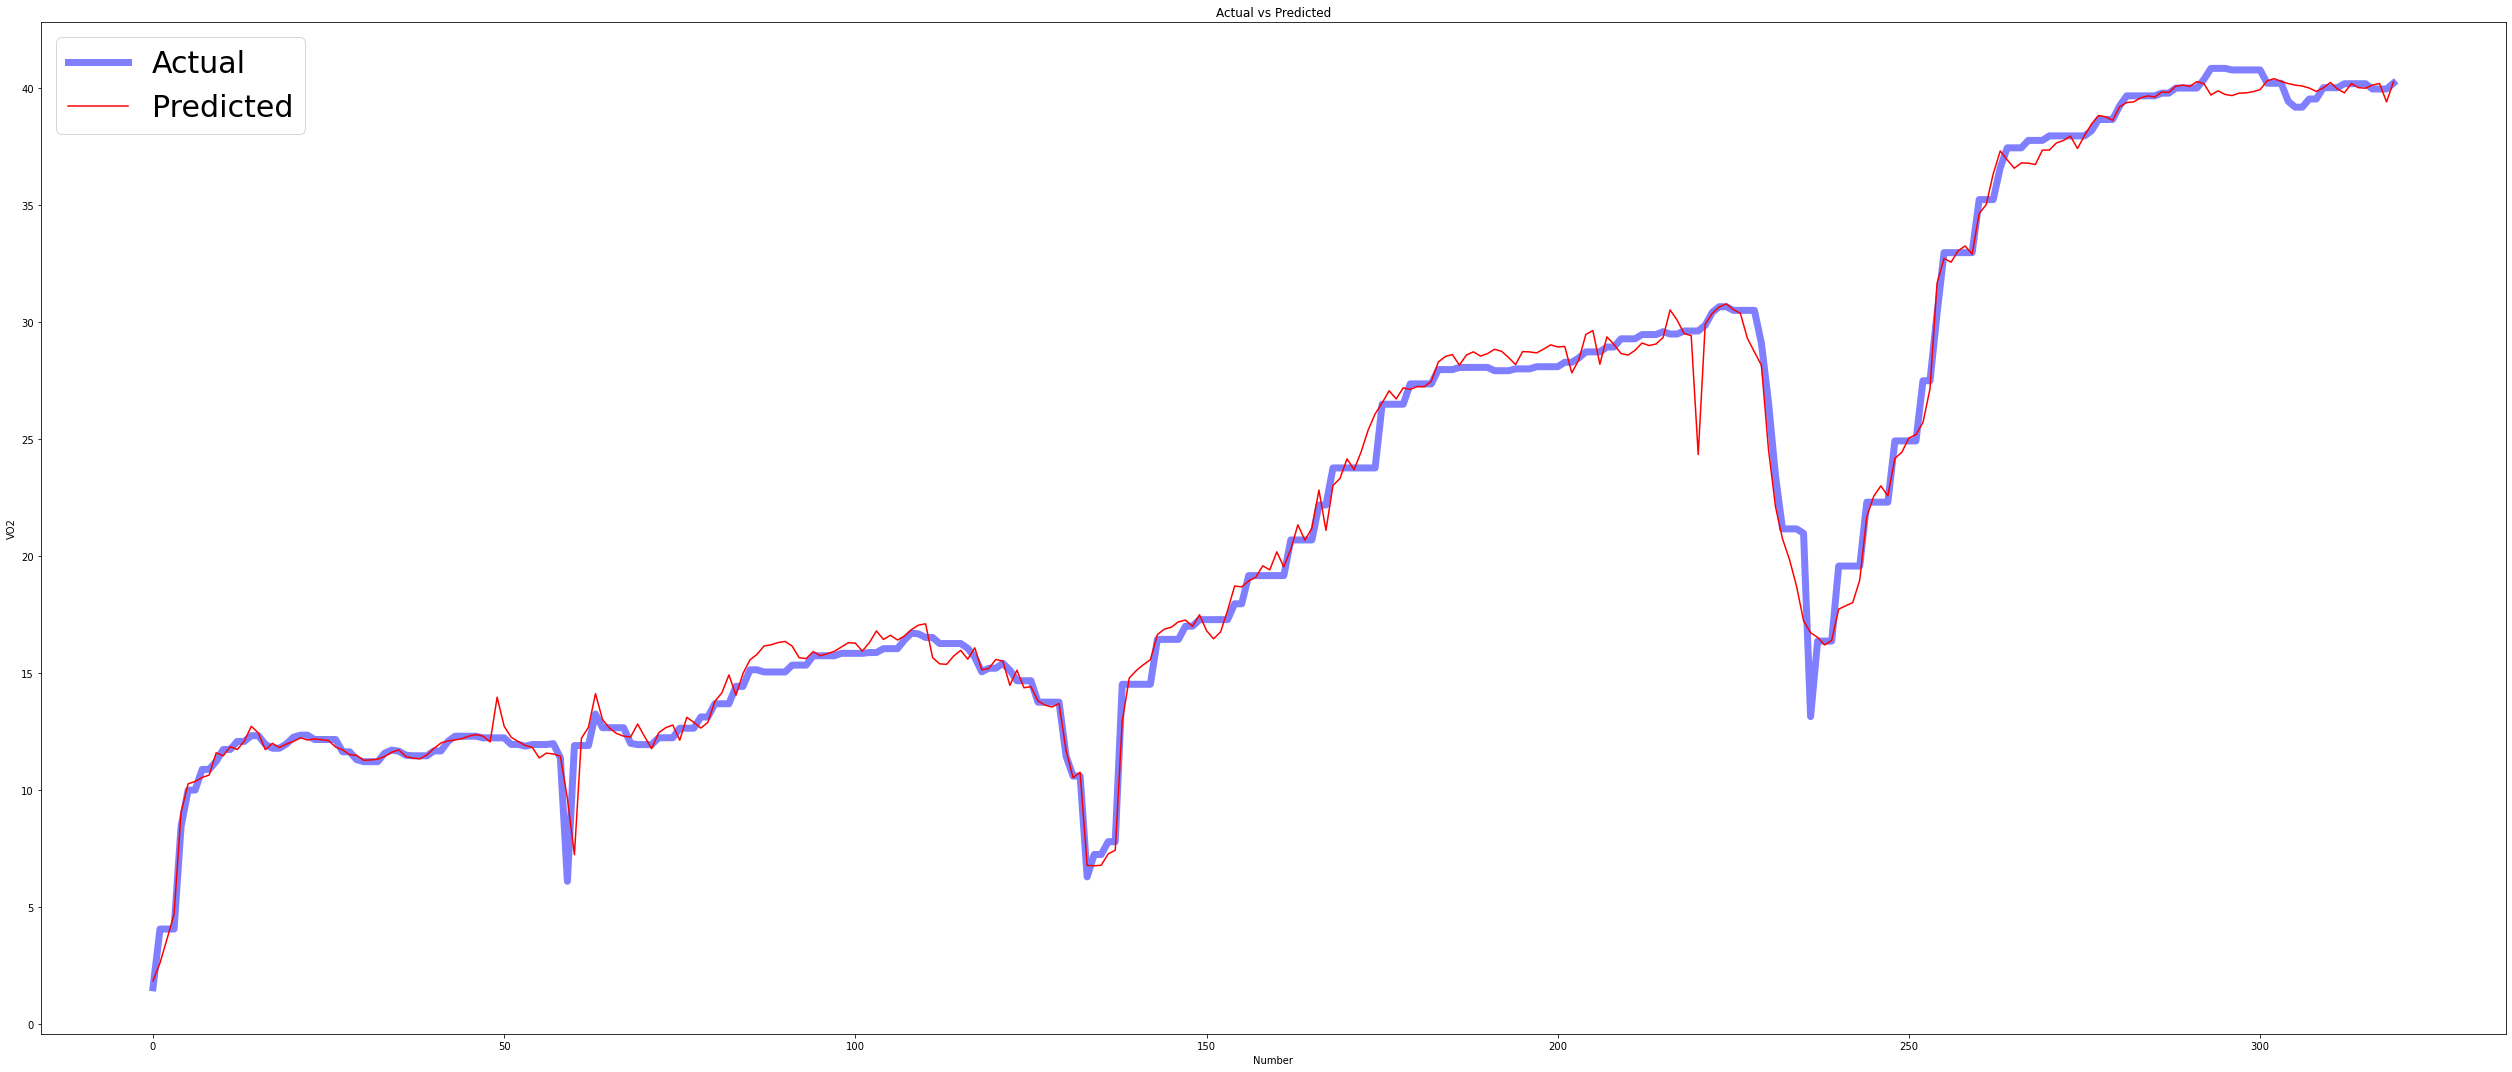

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.figure(figsize=(35,15))
plt.plot(TTest,color='blue',label='Actual',alpha=0.5,linewidth=7.0)
plt.plot(Y_hat,color='red',label='Predicted')
plt.xlabel('Number')
plt.ylabel('VO2')
plt.title('Actual vs Predicted')
plt.tight_layout()
plt.legend(prop={'size': 30})
plt.savefig(figPredictName,bbox_inches='tight',dpi=150)
plt.show()

## Save model

In [11]:
if savedModel:
    model.save(modelSaveName)

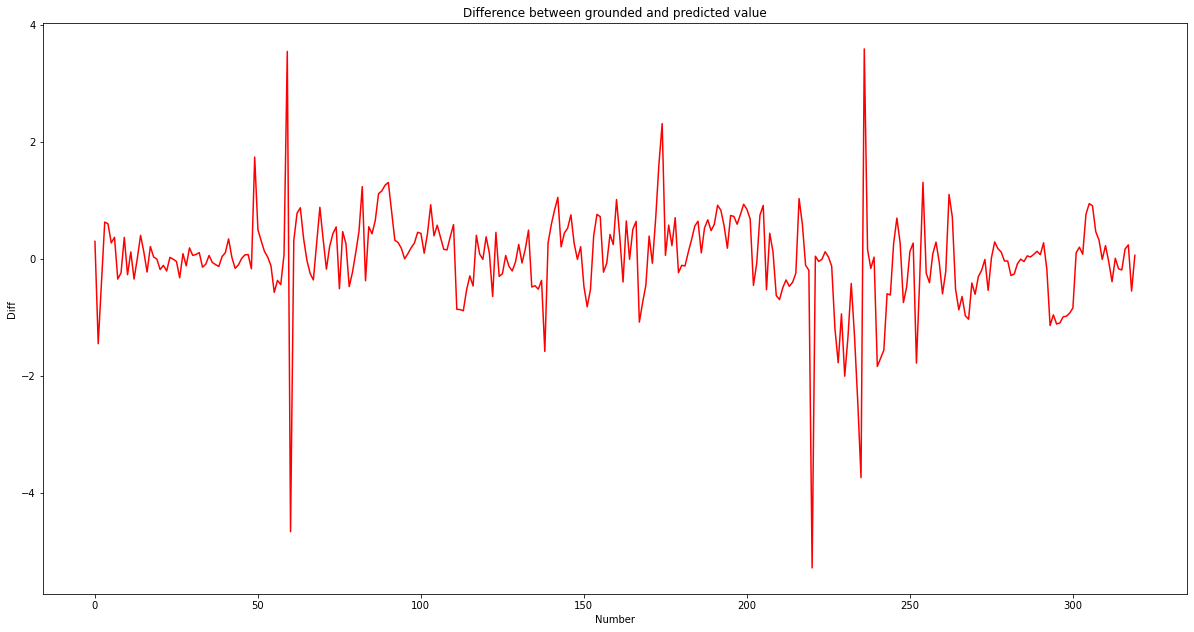

In [12]:
#Y_hat=np.transpose(Y_hat)
TTest=TTest.reshape(len(TTest),1)
#print(Y_hat)
#diff=np.concatenate((Y_hat,TTest),axis=1)
diff=np.subtract(Y_hat,TTest)
#print(diff)

plt.figure(figsize=(20.5,15.5))
plt.plot(diff,color='red')
plt.xlabel('Number')
plt.ylabel('Diff')
plt.title('Difference between grounded and predicted value')
fig = plt.gcf()
fig.set_size_inches(20.5, 10.5)
#fig.savefig('1st-stage-subj-1_L'+results+'.jpg', dpi=150)
plt.show()
#model.save('1st-stage-subj-1.h5')

In [13]:
# print(TTest.shape)
# print(XTest.shape)
# print(XTrain.shape)
# print(TTrain.shape)

In [14]:
# print(TTest)

In [15]:
res=np.concatenate((Y_hat,TTest,Y_hat-TTest,(Y_hat+TTest)/2),axis=1)
print(res)

if exportCSV:
    pd.DataFrame(res).to_csv('Subj-'+subjectID+'-predict.csv')


[[ 1.85989285  1.5625      0.29739285  1.71119642]
 [ 2.62532902  4.075      -1.44967098  3.35016451]
 [ 3.65182638  4.075      -0.42317362  3.86341319]
 ...
 [40.20728302 39.97        0.23728302 40.08864151]
 [39.41952896 39.97       -0.55047104 39.69476448]
 [40.28229523 40.222       0.06029523 40.25214761]]
